# Preprocessing Data

The given dataset provides large, cloud-optimized Geotiff files of several gigabytes. To calculate features on single roof images, they are cut out using the roof polygon coordinates in `train-<region>.geojson` and `test-<region>.geojson`.
Every roof image is stored as a single tif-file.

Data is handled __by region,__ i.e. every region gets its own folder of training and test images.
Training images are sorted into different __subfolders respective of the material__ label. Test images are all put into the same folder, since their material is unknown.

The preprocessing step adds folders `roofs_train` and `roofs_test` to the existing file tree, resulting in a structure as follows:

```
data
└───region1
│   │   train-region1.geojson
│   │   region1_ortho-cog.tif
│   │   ...
│   └───roofs_train
│   │   └───healthy_metal
│   │       │   roof_id_a.tif
│   │       │   roof_id_b.tif
│   │       │   ...
│   │ 
│   │   └───irregular_metal
│   │       │   ...
│   │   └───concrete_cement
│   │       │   ...
│   │   └───incomplete
│   │       │   ...
│   │   └───other
│   │       │   ...
│   │
│   └───roofs_test
│       │   roof_id_m.tif
│       │   roof_id_n.tif
│       │   ...
│
└───region2
│   │   ...
```

In [1]:
import rasterio
import logging
from tqdm import tqdm
import sys
from rasterio.mask import mask
from pyproj import Transformer

import numpy as np
import json
from os.path import join, exists
from os import makedirs
import matplotlib
import matplotlib.pyplot as plt

## 1. Get an overview of a single scenery

Show a thumbnail of the image.

In [2]:
def show_thumbnail(image_fp):
    dec_factor = 32
    with rasterio.open(image_fp) as src:
        b, g, r = (src.read(k,
                            out_shape=(1, int(src.height // dec_factor),
                                          int(src.width // dec_factor)),
                            fill_value=255) for k in (1, 2, 3))

    img = np.array([b, g, r]).transpose(1, 2, 0)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 2. Cut out training roofs and store as separate files

Create subfolders for test and training samples of every region. The training directory gets subfolders for each material.

In [3]:
def create_save_dirs(train_dir, test_dir):
    makedirs(test_dir, exist_ok=True)
    
    materials = ['healthy_metal', 'irregular_metal', 'concrete_cement', 'incomplete', 'other']
    for mat in materials:
        mat_dir = join(train_dir, mat) 
        makedirs(mat_dir, exist_ok=True)

Coordinates in GeoJSON label file need to be converted to the CSR format of the image.

In [4]:
def create_transformer(image_fp):
    with rasterio.open(image_fp) as src:
        transformer = Transformer.from_crs('epsg:4326', # lat/lon coordinate format
                                           src.profile['crs'], # CRS format of image
                                           always_xy=True)
    return transformer

#### Cutting out roofs
1. Extract the roof id and polygon coordinates from GeoJSON label file
2. Convert the lat/lon coordinates to image coordinates
3. Cut the polygon out of the image
4. Save the cut out image of the roof to file with id as name

In [5]:
def cut_out_roofs(save_dir, geojson_fp, image_fp, coord_transformer):

    with open(geojson_fp) as geojson:
        geoms = json.loads(geojson.read())
        roofs = geoms['features']

    with rasterio.open(image_fp) as image, tqdm(total=len(geoms['features']), file=sys.stdout) as pbar:
        for i, roof in enumerate(roofs):
                
            roof_id = roof['id']
            roof_geom = roof['geometry']  
            pbar.update(1)

            # There are about 10 Multipolygons in the whole dataset.
            # I chose to ignore them for training instead of writing a special function to cut them out.
            if roof_geom['type'] == 'MultiPolygon':
                continue

            coord = roof_geom['coordinates'][0]
            for c in coord:
                c[0], c[1] = coord_transformer.transform(c[0], c[1])

            # Cut out the roof from the original image
            roof_image, roof_transform = mask(image, [roof_geom], filled=True, crop=True)

            # Copy metadata from original image but update important parameters
            roof_meta = image.meta.copy()
            roof_meta.update({"driver": "GTiff",
                "dtype": rasterio.uint8,
                "height": roof_image.shape[1],
                "width": roof_image.shape[2],
                "transform": roof_transform,
                "tiled": True,
                "compress": 'lzw'})
            
            # Save to file
            if "roof_material" in roof['properties']:
                roof_material = roof['properties']['roof_material']
                roof_image_fp = join(save_dir, roof_material, str(roof_id)+".tif")
            else:
                roof_image_fp = join(save_dir, str(roof_id)+".tif")
            with rasterio.open(roof_image_fp, "w", **roof_meta) as dest:
                dest.write(roof_image)

Do it for a single image or do it all in one go

In [6]:
sets = [('colombia', 'borde_rural'),
        ('colombia', 'borde_soacha'),
        ('guatemala', 'mixco_1_and_ebenezer'), 
        ('guatemala', 'mixco_3'),
        ('st_lucia', 'dennery')
        #('st_lucia', 'gros_islet'), 
        #('st_lucia', 'castries')
       ]

---------------------
Preprocessing region Borde Rural in Colombia


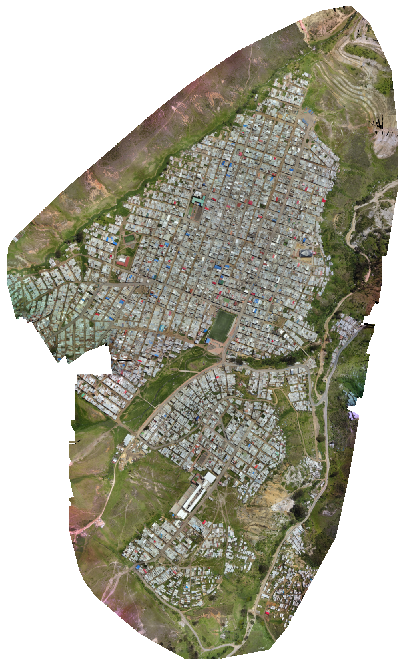

Processing training set
100%|██████████| 4361/4361 [02:33<00:00, 28.42it/s]
Processing test set
100%|██████████| 2160/2160 [01:24<00:00, 25.69it/s]
---------------------
Preprocessing region Borde Soacha in Colombia


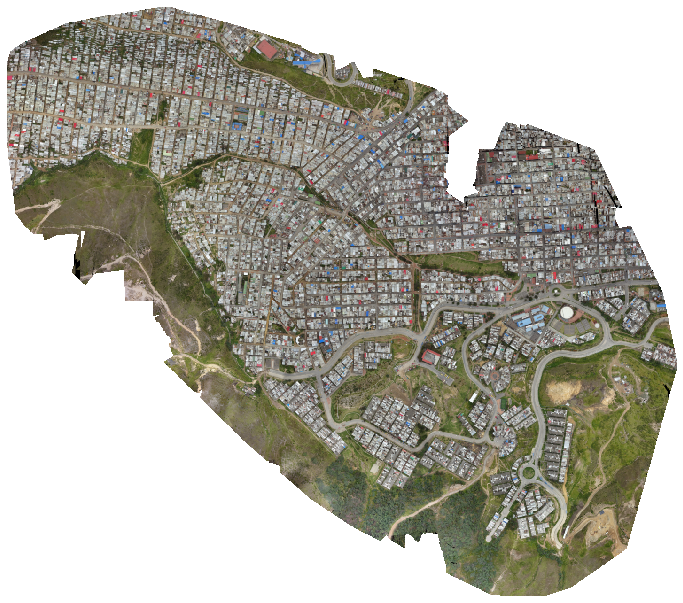

Processing training set
100%|██████████| 5995/5995 [02:59<00:00, 33.31it/s]
Processing test set
100%|██████████| 3017/3017 [01:36<00:00, 31.23it/s]
---------------------
Preprocessing region Mixco 1 And Ebenezer in Guatemala


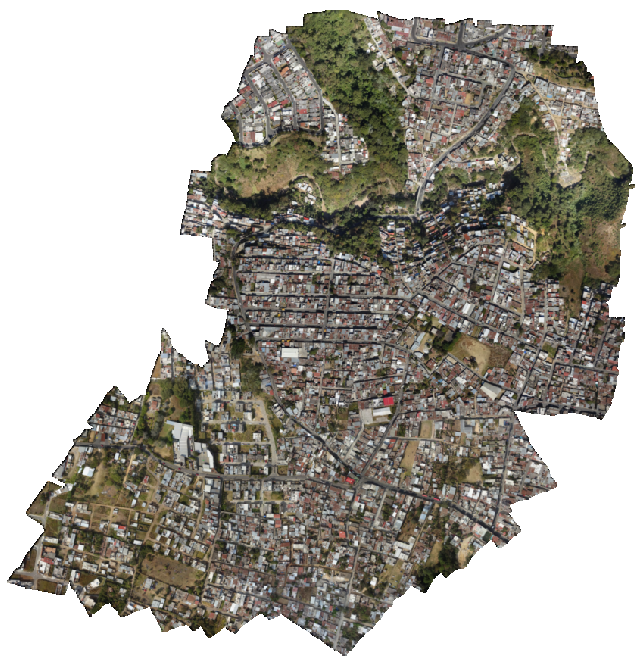

Processing training set
100%|██████████| 3351/3351 [01:49<00:00, 30.56it/s]
Processing test set
100%|██████████| 1568/1568 [00:56<00:00, 27.78it/s]
---------------------
Preprocessing region Mixco 3 in Guatemala


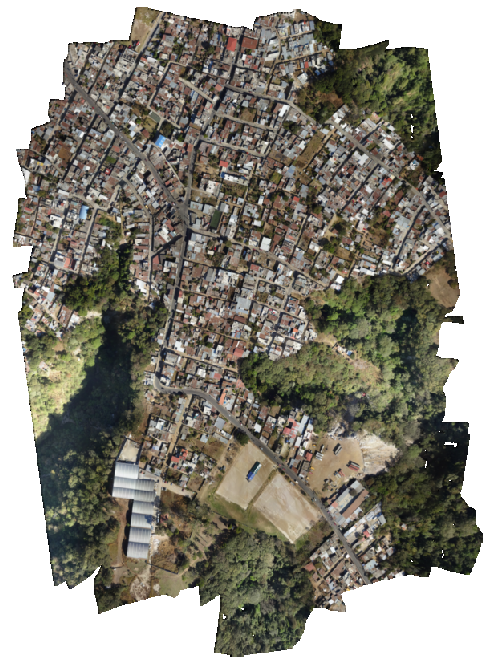

Processing training set
100%|██████████| 159/159 [00:27<00:00,  5.78it/s]
Processing test set
100%|██████████| 58/58 [00:02<00:00, 21.96it/s]
---------------------
Preprocessing region Dennery in St_Lucia


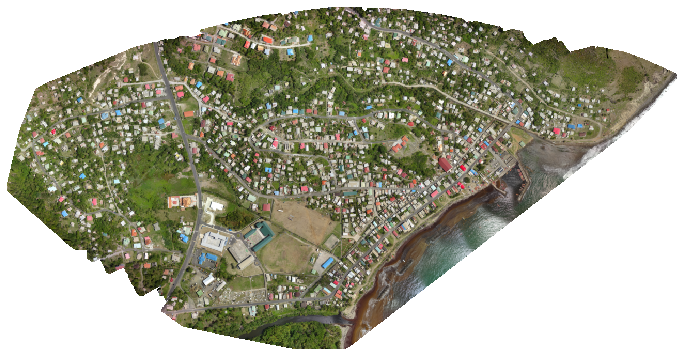

Processing training set
100%|██████████| 1004/1004 [00:54<00:00, 18.33it/s]
Processing test set
100%|██████████| 522/522 [00:44<00:00, 11.64it/s]


In [7]:
for country, region in sets:
    
    region_title = region.replace('_', ' ').title()
    print("---------------------")
    print(f"Preprocessing region {region_title} in {country.title()}")
    
    region_fp = join('..', '..', 'stac', country, region)
    image_fp = join(region_fp, region+'_ortho-cog.tif')
    
    geojson_train_fp = join(region_fp, 'train-'+region+'.geojson')
    geojson_test_fp = join(region_fp, 'test-'+region+'.geojson')
    
    train_dir = join(region_fp, 'roofs_train')
    test_dir = join(region_fp, 'roofs_test')
    create_save_dirs(train_dir, test_dir)
    
    show_thumbnail(image_fp)
    coord_transformer = create_transformer(image_fp)
    
    print("Processing training set")
    cut_out_roofs(train_dir, geojson_train_fp, image_fp, coord_transformer)
    print("Processing test set")
    cut_out_roofs(test_dir, geojson_test_fp, image_fp, coord_transformer)